# PyTorch 学习
当前主机版本是cpu_only

In [1]:
import torch
from torch.autograd import Variable
print(torch.__version__)
print(torch.cuda.is_available())

1.3.1
False



## 线性回归
1. `linspace` 生成100个[a,b]之间间隔均匀的数字
2. `randn` 生成满足正态分布的随机数
3. **绘制数据前要用data获取Variable包裹的Tensor并转成numpy.ndarray**
4. `expand_as(other) / expand(other.size())` 可以升维  
5. `ariable.data.zero_()` 可以清空数值

93.446434


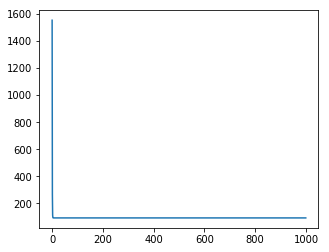

In [14]:
import matplotlib.pyplot as plt

x = Variable(torch.linspace(0,99).type(torch.FloatTensor))
r = Variable(torch.randn(100))*10

y = x+r

a = Variable(torch.rand(1), requires_grad = True)
b = Variable(torch.rand(1), requires_grad = True)

J = []
learning_rate = 0.0001
for i in range(1000):
    # 每次迭代要清空存储在变量a，b中的梯度信息以免在backward过程中反复累加
    if (a.grad is not None) and (b.grad is not None):
        a.grad.data.zero_()
        b.grad.data.zero_()
    y_hat = a.expand_as(x) * x + b.expand_as(x)
    loss = torch.mean((y_hat - y)**2)
    J.append(loss)
    loss.backward()
    a.data.add_(- learning_rate * a.grad.data)
    b.data.add_(- learning_rate * b.grad.data)

print(loss.data.numpy())

plt.figure(figsize = (5,4))
plt.plot(J)
plt.show()

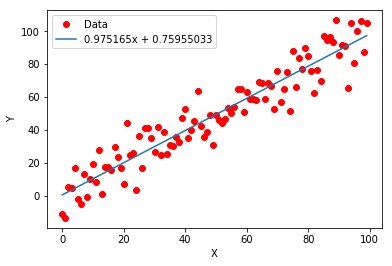

In [15]:
X = x.data.numpy()
Y = y.data.numpy()
xplot, = plt.plot(X, Y, 'ro')
yplot, = plt.plot(X, a.data.numpy()*X+b.data.numpy())
plt.xlabel('X')
plt.ylabel('Y')
line = str(a.data.numpy()[0])+'x + '+str(b.data.numpy()[0])
plt.legend([xplot,yplot],['Data',line])
plt.show()

## 简单三层NN的回归任务
使用[共享单车数据](http://labfile.oss.aliyuncs.com/courses/1073/bike-sharing-dataset.zip)，对单车使用量的预测
### 数据处理

因为数据文件中的数据具有不同的数据类型，不同的取值范围，所以要先预处理。

#### 处理不同类型特征
- 类型变量：value仅表示不同的类型，无高低之分，不能直接输入到神经网络，因为数值越高并不表示信号强度越大，对于此类变量可以用one-hot来编码。`pandas.get_dummies()`可以用于one-hot编码
- 数值型变量：每个数值型变量都是独立的，如温度，其绝对值大小与问题本身无关，为了消除数值大小的差异，可以对每一个数值型变量进行标准化处理，让其数值都围绕着0波动（var-mean）/std

#### 数据集分割
- 在变量集合上，分为特征和目标两个集合
- 将所有数据划分为训练集、（验证集）和测试集


1. pandas的head方法可以将数据的表头和部分数据打印出来
2. `DataFrame.loc[]` 可以按照索引来选择行列
3. `DataFrame.values` 可以转换为numpy.ndarray
4. `array.astype(floiat)`保证数据实数

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data_path = 'bike-sharing-dataset/hour.csv'
data = pd.read_csv(data_path)

# 对于类型变量season，weathesit，mnth，hr，weekday可以用one-hot编码
# seanson就会变成season_1，season_2, season_3, season_4
dummy_fields = ['season','mnth','hr','weekday','weathersit']
data = pd.get_dummies(data, columns=dummy_fields)
no_use = ['instant','dteday','atemp','workingday']
bikes = data.drop(no_use,axis=1)
bikes.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [5]:
# 对于数值型变量的归一化
quants = ['cnt','temp','hum','windspeed']
scaled_feature = {} #将均值和方差存储起来，用于之后的测试数据的预测值与真实值的对比
for i in quants:
    mean, std = bikes[i].mean(), bikes[i].std()
    scaled_feature[i] = [mean, std]
    bikes.loc[:,i] = (bikes[i] - mean)/std

# 划分数据集
test_data = bikes[-21*24:]
train_data = bikes[:-21*24]

targets = ['cnt','casual','registered']
train_feature, train_target = train_data.drop(targets,axis=1), train_data[targets]
test_feature, test_target = test_data.drop(targets,axis=1), test_data[targets]

X = train_feature.values
Y = train_target['cnt'].values # cnt代表用户数，即使用量
Y = Y.astype(float)
Y = Y.reshape([len(Y),1])

## 定义神经网络
1. `torch.nn.Sequential`可以将一系列运算模块按顺序搭建成一个多层的神经网络
2. `torch.nn.Linear()`是从输入到输出的线型映射
3. `torch.nn.Sigmoid()` logic function
4. `torch.nn.MSELoss()`是计算均方误差的损失函数，是一个函数指针，赋给变量cost后还需要调用cost(x,y)
5. `torch.optim.SGD()`SGD

In [8]:
input_size = train_feature.shape[1]
hidden_size = 10
output_size = 1
batch_size = 128

nn = torch.nn.Sequential(
        torch.nn.Linear(input_size, hidden_size),
        torch.nn.Sigmoid(),
        torch.nn.Linear(hidden_size,output_size),
)
cost = torch.nn.MSELoss()
optimizer = torch.optim.SGD(nn.parameters(), lr=0.01)

losses = []
for i in range(2000):
    batch_loss = []
    for start in range(0, X.shape[0], batch_size ):
        end = start+batch_size if start+batch_size<len(X) else len(X)
        x = Variable(torch.FloatTensor(X[start:end]))
        y = Variable(torch.FloatTensor(Y[start:end]))
        y_hat = nn(x)
        loss = cost(y_hat,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.data.numpy())
        
    if (i+1)%100 == 0:
        losses.append(np.mean(batch_loss))
        print('{} step loss: {}'.format(i+1, np.mean(batch_loss)))
        
plt.plot(np.arange(len(losses))*100,losses,'o-')
plt.xlabel('epoch')
plt.ylabel('MSE')

100 step loss: 0.27889516949653625
200 step loss: 0.23993229866027832
300 step loss: 0.171216681599617
400 step loss: 0.11047184467315674
500 step loss: 0.08158671855926514
600 step loss: 0.07113143801689148
700 step loss: 0.0667930543422699
800 step loss: 0.06436645984649658
900 step loss: 0.06277201324701309
1000 step loss: 0.06163715571165085
1100 step loss: 0.060773227363824844
1200 step loss: 0.060066286474466324
1300 step loss: 0.059441111981868744
1400 step loss: 0.058845579624176025
1500 step loss: 0.05825112760066986
1600 step loss: 0.057665083557367325
1700 step loss: 0.057122718542814255
1800 step loss: 0.056646525859832764
1900 step loss: 0.05622846260666847
2000 step loss: 0.05585019290447235


## 测试
1. `fig,ax = plt.subplots()`返回一个包含figure和axes对象的元组

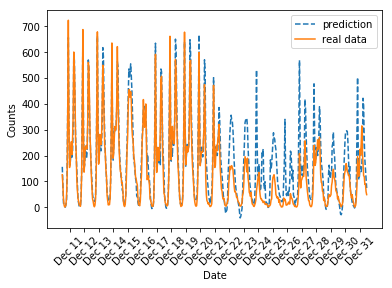

In [11]:
# 测试
real = test_target['cnt']
real = real.values.reshape([len(real),1])
real = real.astype(float)

yy = Variable(torch.FloatTensor(real))
xx = Variable(torch.FloatTensor(test_feature.values))

yy_hat = nn(xx)
yy_hat = yy_hat.data.numpy()
# 将预测数据与真实数据画在一起比较
fig, ax = plt.subplots()

mean, std = scaled_feature['cnt']
ax.plot(yy_hat*std+mean, label='prediction', linestyle = '--')
ax.plot(yy*std+mean, label='real data', linestyle='-')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Counts')
# 对横坐标坐标轴标注
dates = pd.to_datetime(data.loc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation =45)

## CNN


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms

### 数据预处理
**PyTorch 数据加载三套件：**
当数据格式比较特殊，以及数据规模很大（内存无法同时加载所有数据）时，可以使用pytorch自带的数据加载器，`dataset`,`sampler`以及`data_loader`这三个对象组成的三套件。特别是当需要不同的处理器来并行加载数据时，pytorch数据加载器还可以自动地进行数据的分布式加载。
> `dataset`用来装载数据集，`sampler`用来采样数据集，`data_loader`完成数据集的迭代和循环。

In [4]:
# Hyperparameters
img_size = 28
num_classes = 10
num_epochs = 20 
batch_size = 64

# 数据预处理
# torchvision 自带MNIST，可以直接调用
train_dataset = dsets.MNIST(root='./data', #存放路径
                           train=True, # 提取训练集
                           transform=transforms.ToTensor(), # 将图像转化为tensor
                           download=True) # 找不到文件时自动下载
test_dataset = dsets.MNIST(root='./data',train=False,transform = transforms.ToTensor())

# 训练数据集的加载器，自动将数据分割成batch，顺序随机打乱
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size = batch_size,
                                          shuffle = True)
# 测试数据集划分为validate和test数据
# 创建test_dataset中所有数据的索引
indices = range(len(test_dataset))
indices_val = indices[:5000]
indices_test = indices[5000:]

# 定义采样器，可以从数据集中随机采样
# 根据分好的下标，构造两个数据集的 SubsetRandomSampler 采样器，会对下标进行采样
sampler_val = torch.utils.data.sampler.SubsetRandomSampler(indices_val)
sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices_test)

# 验证集数据加载器
val_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                        batch_size = batch_size,
                                        sampler = sampler_val)
# 测试集数据加载器
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = batch_size,
                                         sampler = sampler_test)

### 构建CNN
1. 首先构造ConvNet类，是对nn.Module的继承
2. 重写父类的`init`和`forward`函数
3. 在ConvNet类中编写自定义的方法

In [ ]:
# 卷积核厚度
depth = [4,8]
class ConvNet(nn.Module):
    def __init__(self):
        # 首先调用父类相应的构造函数
        super(ConvNet, self).__init__()
        # 其次构造ConvNet需要用到的各个神经模块
        self.conv1 = nn.Conv2d(1,4,5,padding=2) #输入1，输出4，窗口5